In [54]:
import pandas as pd
temp_rain_soil = pd.read_csv("../AucklandCouncilOpenData_08June24/temp_rain_soil_Auckland_2015-10-21to2024-06-08.csv", index_col='Timestamp (UTC+12:00)', parse_dates=True)
temp_rain_soil.head()

,Temp,Rain(mm),SoilMoist,SoilTemp
Timestamp (UTC+12:00),,,,
2018-07-07 11:00:00,14.0,0.0,37.51600,10.400
2018-07-07 12:00:00,15.0,0.0,37.52375,10.600
2018-07-07 13:00:00,16.0,0.0,37.57200,10.700
2018-07-07 14:00:00,16.0,0.0,37.34300,10.725
2018-07-07 15:00:00,16.0,0.0,37.35050,10.950


In [55]:
temp_rain_soil.tail()

,Temp,Rain(mm),SoilMoist,SoilTemp
Timestamp (UTC+12:00),,,,
2023-08-23 00:00:00,11.0,0.0,50.77650,11.90
2023-08-23 01:00:00,11.0,0.0,50.82350,11.90
2023-08-23 02:00:00,11.0,0.0,50.82475,11.90
2023-08-23 03:00:00,11.0,0.0,50.85500,11.65
2023-08-23 04:00:00,10.0,0.0,50.95325,11.60


In [56]:
# Print the number of missing entries in each column
temp_rain_soil.isnull().sum()

Temp         0
Rain(mm)     0
SoilMoist    0
SoilTemp     0
dtype: int64

In [57]:
temp_rain_soil.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44946 entries, 2018-07-07 11:00:00 to 2023-08-23 04:00:00
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Temp       44946 non-null  float64
 1   Rain(mm)   44946 non-null  float64
 2   SoilMoist  44946 non-null  float64
 3   SoilTemp   44946 non-null  float64
dtypes: float64(4)
memory usage: 1.7 MB


In [58]:
temp_rain_soil.describe()

,Temp,Rain(mm),SoilMoist,SoilTemp
count,44946.000000,44946.000000,44946.000000,44946.000000
mean,17.030748,0.150908,42.812377,17.232820
std,3.723188,0.921601,4.625684,3.617801
min,7.000000,0.000000,34.973250,9.400000
25%,14.000000,0.000000,39.171813,13.925000
50%,17.000000,0.000000,42.342971,17.146250
75%,20.000000,0.000000,46.088687,20.477500
max,29.000000,45.000000,53.104000,24.900000


In [59]:
sorted_temp = temp_rain_soil['Temp'].unique()
print(sorted_temp.sort())

None


In [60]:
sorted_rain = temp_rain_soil['Rain(mm)'].unique()
print("Sorted Rain(mm):")
print(sorted_rain.sort())

Sorted Rain(mm):
None


<Axes: xlabel='Timestamp (UTC+12:00)'>

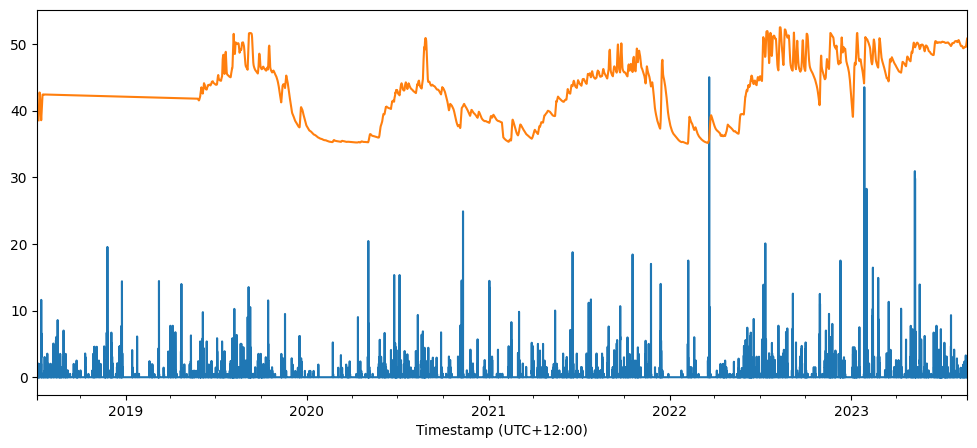

In [61]:
# rolling to see average soil moist
temp_rain_soil['Rain(mm)'].plot(figsize=(12,5))
temp_rain_soil.rolling(window=60).mean()['SoilMoist'].plot()

In [62]:
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
from math import sqrt

In [63]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(temp_rain_soil[['Rain(mm)', 'SoilMoist']], test_size=0.3, shuffle=False)
print(f"Train data length: {len(train_data)}")
print(f"Test data length: {len(test_data)}")

Train data length: 31462
Test data length: 13484


In [64]:
model = VAR(train_data)
model_fit = model.fit()

f:\YingYing\Level8\Data Science\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


In [65]:
print("AIC:", model_fit.aic)
print("BIC:", model_fit.bic)

AIC: -5.682255410080732
BIC: -5.680661721902511


In [66]:
forecast_steps = len(test_data)
lag_order = model_fit.k_ar
prediction = model_fit.forecast(train_data.values[-lag_order:], steps=forecast_steps)


In [67]:
rmse_rain = sqrt(mean_squared_error(test_data['Rain(mm)'], prediction[:, 0]))
rmse_soil_moist = sqrt(mean_squared_error(test_data['SoilMoist'], prediction[:, 1]))

print(f"RMSE Rainfall: {rmse_rain}")
print(f"RMSE Soil Moisture: {rmse_soil_moist}")

RMSE Rainfall: 1.3027409277904534
RMSE Soil Moisture: 6.407112629114833


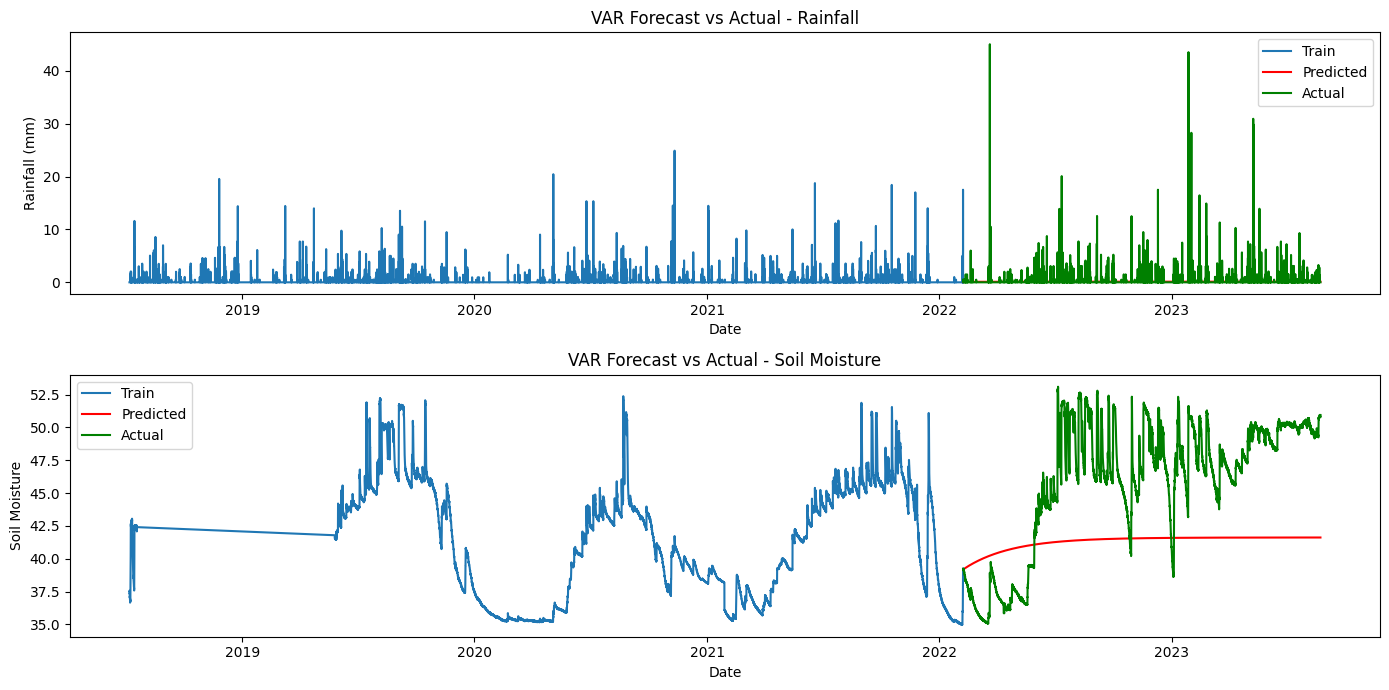

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(train_data.index, train_data['Rain(mm)'], label='Train')
plt.plot(test_data.index, prediction[:, 0], color='red', label='Predicted')
plt.plot(test_data.index, test_data['Rain(mm)'], color='green', label='Actual')
plt.title('VAR Forecast vs Actual - Rainfall')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(train_data.index, train_data['SoilMoist'], label='Train')
plt.plot(test_data.index, prediction[:, 1], color='red', label='Predicted')
plt.plot(test_data.index, test_data['SoilMoist'], color='green', label='Actual')
plt.title('VAR Forecast vs Actual - Soil Moisture')
plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend()

plt.tight_layout()
plt.show()

In [69]:
# Experiment with different lag orders
lags = [1, 2, 3, 4, 5]
best_rmse = float('inf')
best_model = None
best_lag_order = None

In [70]:
for lag in lags:
    model = VAR(train_data)
    model_fit = model.fit(lag)
    
    forecast_steps = len(test_data)
    prediction = model_fit.forecast(train_data.values[-lag:], steps=forecast_steps)
    
    rmse_rain = sqrt(mean_squared_error(test_data['Rain(mm)'], prediction[:, 0]))
    rmse_soil_moist = sqrt(mean_squared_error(test_data['SoilMoist'], prediction[:, 1]))
    
    print(f"Lag Order: {lag}")
    print(f"RMSE Rainfall: {rmse_rain}")
    print(f"RMSE Soil Moisture: {rmse_soil_moist}")
    
    if (rmse_rain + rmse_soil_moist) < best_rmse:
        best_rmse = rmse_rain + rmse_soil_moist
        best_model = model_fit
        best_lag_order = lag

print(f"Best Lag Order: {best_lag_order}")
print(f"Best RMSE: {best_rmse}")

f:\YingYing\Level8\Data Science\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
f:\YingYing\Level8\Data Science\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Lag Order: 1
RMSE Rainfall: 1.3027409277904534
RMSE Soil Moisture: 6.407112629114833
Lag Order: 2
RMSE Rainfall: 1.3027200622514934
RMSE Soil Moisture: 6.423051219134269


f:\YingYing\Level8\Data Science\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
f:\YingYing\Level8\Data Science\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Lag Order: 3
RMSE Rainfall: 1.3027252242042973
RMSE Soil Moisture: 6.4266353462369725
Lag Order: 4
RMSE Rainfall: 1.3027158496015174
RMSE Soil Moisture: 6.421129318067781


f:\YingYing\Level8\Data Science\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Lag Order: 5
RMSE Rainfall: 1.302716901751093
RMSE Soil Moisture: 6.428511291801886
Best Lag Order: 1
Best RMSE: 7.709853556905286


In [71]:
forecast_steps = len(test_data)
prediction = best_model.forecast(train_data.values[-best_lag_order:], steps=forecast_steps)


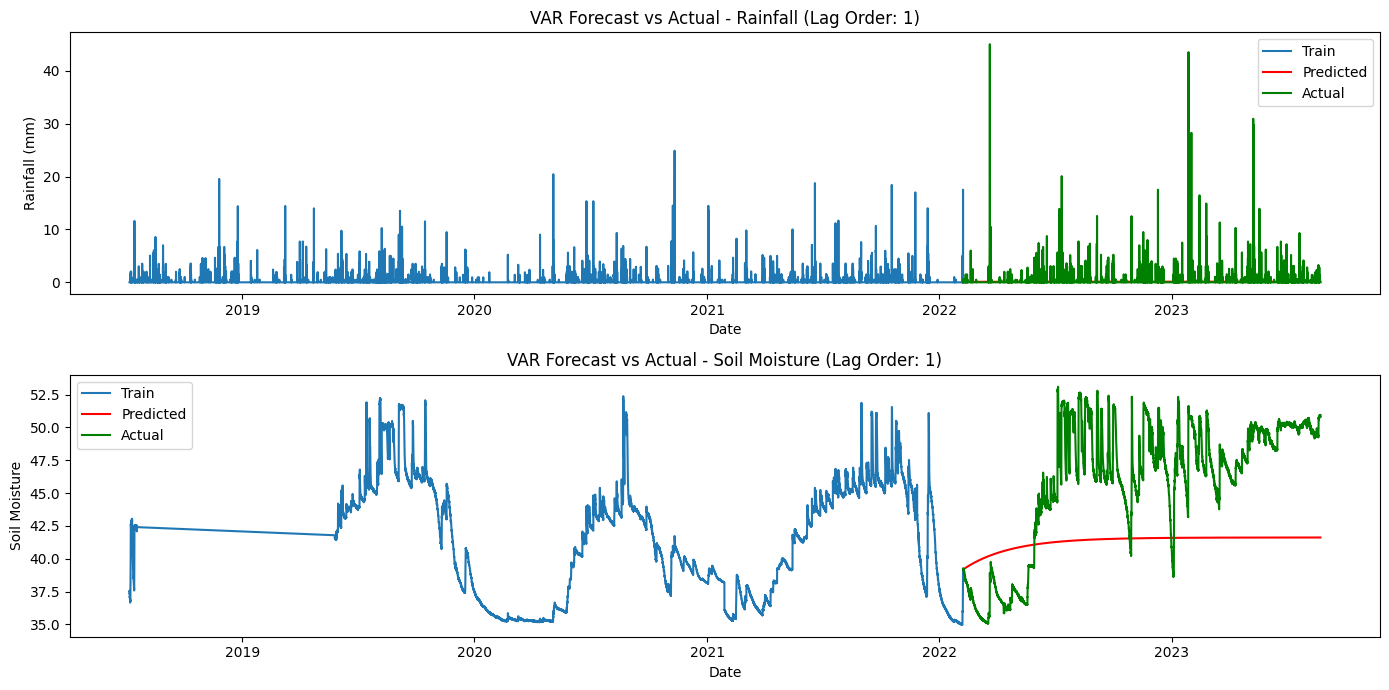

In [72]:
plt.figure(figsize=(14, 7))

# Plotting Rainfall
plt.subplot(2, 1, 1)
plt.plot(train_data.index, train_data['Rain(mm)'], label='Train')
plt.plot(test_data.index, prediction[:, 0], color='red', label='Predicted')
plt.plot(test_data.index, test_data['Rain(mm)'], color='green', label='Actual')
plt.title(f'VAR Forecast vs Actual - Rainfall (Lag Order: {best_lag_order})')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()

# Plotting Soil Moisture
plt.subplot(2, 1, 2)
plt.plot(train_data.index, train_data['SoilMoist'], label='Train')
plt.plot(test_data.index, prediction[:, 1], color='red', label='Predicted')
plt.plot(test_data.index, test_data['SoilMoist'], color='green', label='Actual')
plt.title(f'VAR Forecast vs Actual - Soil Moisture (Lag Order: {best_lag_order})')
plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.legend()

plt.tight_layout()
plt.show()